In [1]:
import numpy as np
import os
# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling, BatchNormalization

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline


print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/train"
img_size = (224, 224)  # Taille cible
batch_size = 128
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

print(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Calcule du poids des classes pour gérer le déséquilibre
all_labels = []
for images, labels in train_ds:
    all_labels.extend(labels.numpy())

# Convertir en array numpy
all_labels = np.array(all_labels)

# Identifier les classes uniques
unique_classes = np.unique(all_labels)

# Calculer les poids avec sklearn
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=all_labels
)
    
# Créer un dictionnaire de poids
class_weights = {cls: weight for cls, weight in zip(unique_classes, weights)}

# Méthode d'analyse des résultats
def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2025-03-17 22:08:40.884168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742245720.923733   23461 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742245720.936854   23461 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742245721.000864   23461 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742245721.000886   23461 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742245721.000887   23461 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905', '40', '50', '60']
Found 77316 files belonging to 27 classes.
Using 61853 files for training.


I0000 00:00:1742245780.518932   23461 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 77316 files belonging to 27 classes.
Using 15463 files for validation.


2025-03-17 22:11:09.682544: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Définition des couches partagées

In [2]:
def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()






## modèle MobileNetV2

Phase 1: Entraînement des couches supérieures
Epoch 1/10


I0000 00:00:1742245892.269364   23826 cuda_dnn.cc:529] Loaded cuDNN version 90800


484/484 ━━━━━━━━━━━━━━━━━━━━ 106s 202ms/step - accuracy: 0.0553 - loss: 3.4452 - val_accuracy: 0.2434 - val_loss: 2.8619 - learning_rate: 1.0000e-04
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 100s 207ms/step - accuracy: 0.1500 - loss: 2.9436 - val_accuracy: 0.3418 - val_loss: 2.4579 - learning_rate: 1.0000e-04
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 96s 198ms/step - accuracy: 0.2100 - loss: 2.6944 - val_accuracy: 0.3734 - val_loss: 2.2743 - learning_rate: 1.0000e-04
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 96s 198ms/step - accuracy: 0.2444 - loss: 2.5845 - val_accuracy: 0.3903 - val_loss: 2.1810 - learning_rate: 1.0000e-04
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 93s 193ms/step - accuracy: 0.2694 - loss: 2.4767 - val_accuracy: 0.4039 - val_loss: 2.1038 - learning_rate: 1.0000e-04
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 96s 198ms/step - accuracy: 0.2874 - loss: 2.4305 - val_accuracy: 0.4104 - val_loss: 2.0644 - learning_rate: 1.0000e-04
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step 

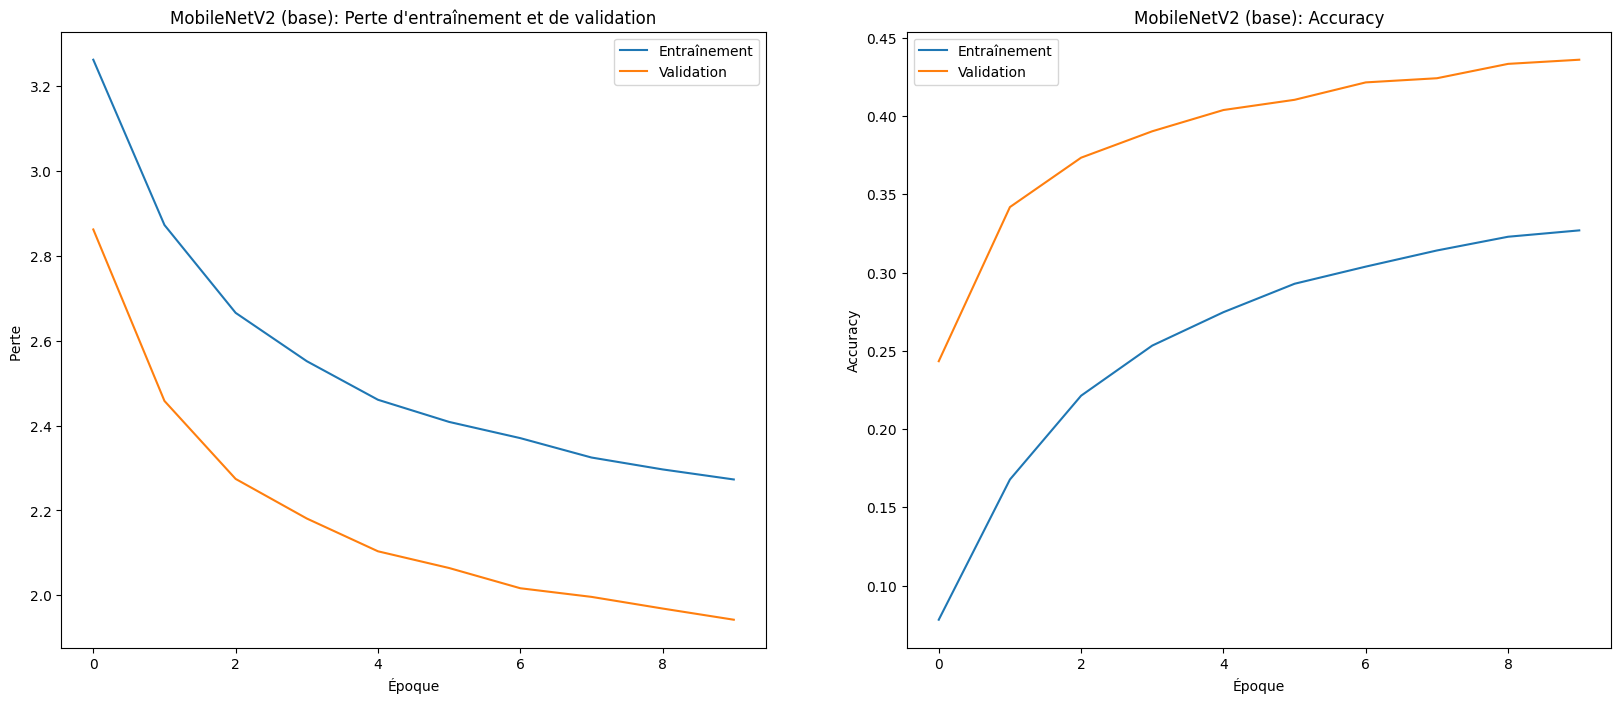

121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.5353 - loss: 1.5413
Précision de validation finale: 0.5434


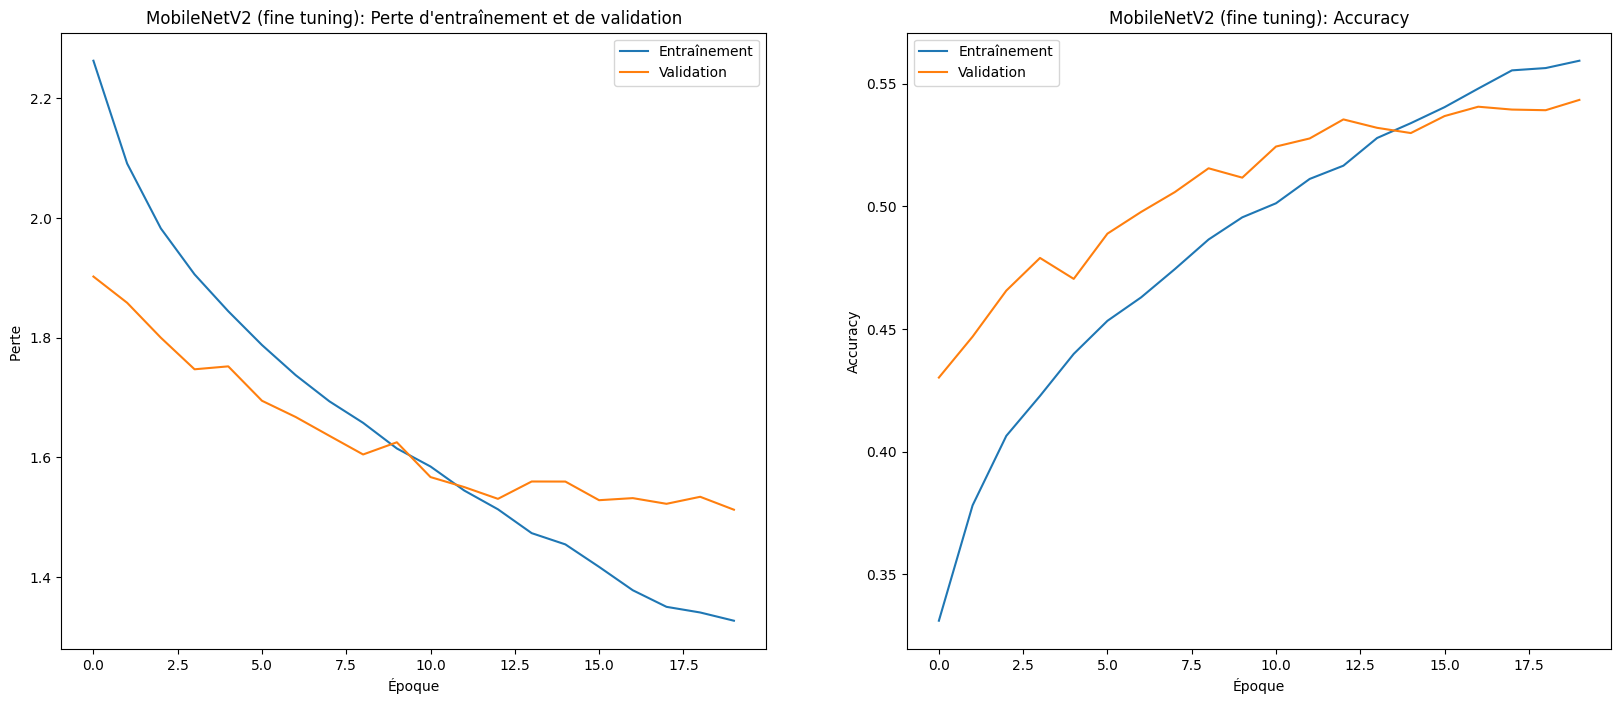

4/4 ━━━━━━━━━━━━━━━━━━━━ -1s 47ms/step      
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━

2025-03-17 23:16:11.400400: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


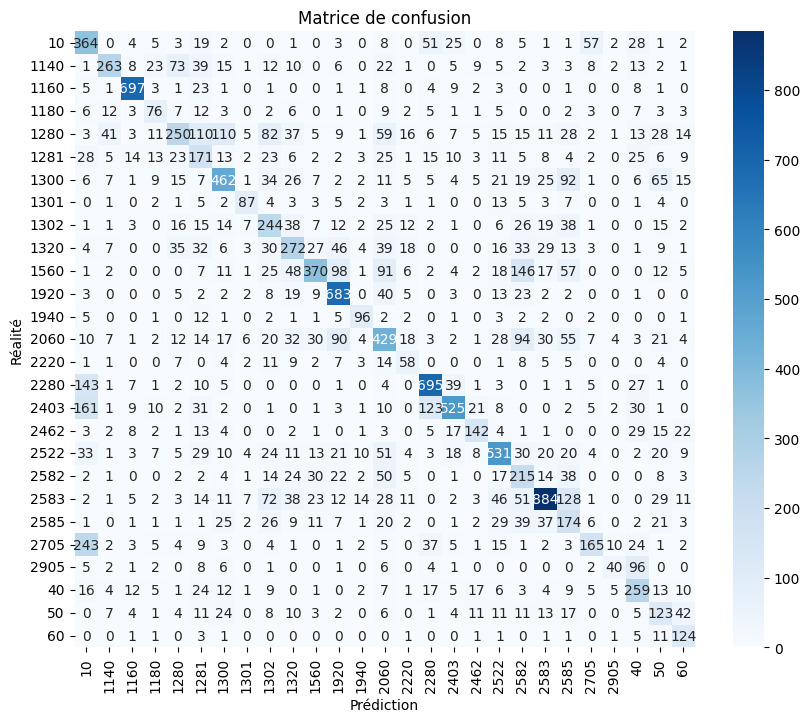

In [3]:
### ARCHITECTURE DU MODEL ###

import tensorflow as tf 
from tensorflow.keras.applications import MobileNetV2

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# 1. Choisir un modèle préentraîné
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Geler d'abord le modèle de base

# 2. Construire le modèle complet
model = tf.keras.Sequential([
    # Augmentation de données
    data_augmentation,
    
    # Normalisation
    tf.keras.layers.Rescaling(1./127.5, offset=-1),  
    
    # Modèle de base
    base_model,
    
    # Couches de classification
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(nb_class, activation='softmax')
])

ReduceLR_callback = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta=0.01,
                                    factor=0.5, 
                                    cooldown=4)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


INITIAL_EPOCHS = 10
FINE_TUNING_EPOCHS = 20

# Première phase: entraîner seulement les couches supérieures
print("Phase 1: Entraînement des couches supérieures")

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])             

model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=INITIAL_EPOCHS,
                           class_weight=class_weights,
                           callbacks=[ReduceLR_callback])       

# Deuxième phase: Fine-tuning
print("Phase 2: Fine-tuning du modèle")

base_model.trainable = False

for layer in base_model.layers[-54:]:  
    layer.trainable = True

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5),                 
    metrics=['accuracy'])             

model_history_fine_tuned = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=INITIAL_EPOCHS + FINE_TUNING_EPOCHS,
                           initial_epoch=model_history.epoch[-1] + 1,
                           class_weight=class_weights,
                           callbacks=[ReduceLR_callback]) 


### ANALYSE DE L ENTRAINEMENT ###

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_history, "MobileNetV2 (base)")

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_history_fine_tuned, "MobileNetV2 (fine tuning)")


### ANALYSE DE LA PERFORMACE ###

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()